In [1]:
! pip install soundata

In [2]:
import soundata

dataset = soundata.initialize('urbansound8k')
dataset.download()  # download the dataset
dataset.validate()  # validate that all the expected files are there

example_clip = dataset.choice_clip()  # choose a random example clip
print(example_clip)  # see the available data


INFO: Downloading ['all', 'index']. Index is being stored in /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/soundata/datasets/indexes, and the rest of files in /Users/keerthana/sound_datasets/urbansound8k
INFO: [all] downloading UrbanSound8K.tar.gz
INFO: /Users/keerthana/sound_datasets/urbansound8k/UrbanSound8K.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [all] downloading UrbanSound8K.tar.gz
INFO: /Users/keerthana/sound_datasets/urbansound8k/UrbanSound8K.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: /Users/keerthana/sound_datasets/urbansound8k/UrbanSound8K_README.txt already exists. Run with force_overwrite=True to download from scratch
INFO: /Users/keerthana/sound_datasets/urbansound8k/FREESOUNDCREDITS.txt already exists. Run with force_overwrite=True to download from scratch
INFO:

Clip(
  audio_path="/Users/keerthana/sound_datasets/urbansound8k/audio/fold6/124389-8-1-12.wav",
  clip_id="124389-8-1-12",
  audio: The clip's audio
    * np.ndarray - audio signal
    * float - sample rate,
  class_id: The clip's class id.
    * int - integer representation of the class label (0-9). See Dataset Info in the documentation for mapping,
  class_label: The clip's class label.
    * str - string class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music,
  fold: The clip's fold.
    * int - fold number (1-10) to which this clip is allocated. Use these folds for cross validation,
  freesound_end_time: The clip's end time in Freesound.
    * float - end time in seconds of the clip in the original freesound recording,
  freesound_id: The clip's Freesound ID.
    * str - ID of the freesound.org recording from which this clip was taken,
  freesound_start_time: The clip's start time in Freesound.
    * fl

In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from tqdm import tqdm

In [4]:
audio_data_path = "./sound_datasets/urbansound8k/"
metadata_file = os.path.join(audio_data_path, "metadata/UrbanSound8K.csv")
print(metadata_file)
df = pd.read_csv(metadata_file)

./sound_datasets/urbansound8k/metadata/UrbanSound8K.csv


In [5]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
def extract_features(audio_file):
    try:
        y, sr = librosa.load(audio_file, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)  # Take mean of each MFCC feature across time frames
        return mfcc_mean
    except Exception as e:
        print(f"Error processing file {audio_file}: {e}")
        return None

In [7]:
features = []
file_names = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    file_name = os.path.join(audio_data_path, "audio", "fold" + str(row["fold"]), row["slice_file_name"])
    feature = extract_features(file_name)
    if feature is not None:
        features.append(feature)
        file_names.append(file_name)

features = np.array(features)

 33%|███▎      | 2838/8732 [00:19<00:38, 152.18it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
100%|██████████| 8732/8732 [00:56<00:00, 153.43it/s]


In [8]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [9]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

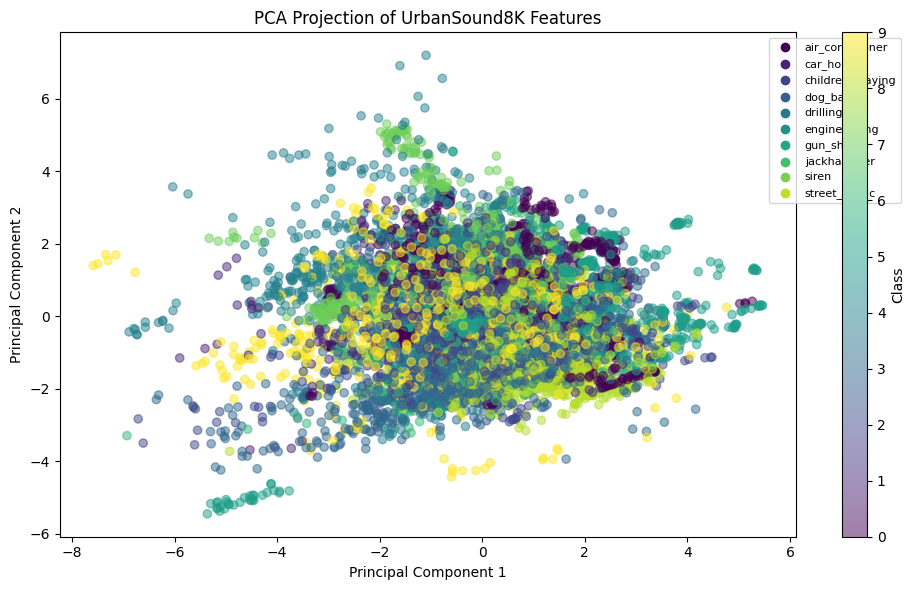

In [10]:
from sklearn.preprocessing import LabelEncoder

# Encode class labels to numeric values for color mapping
le = LabelEncoder()
class_encoded = le.fit_transform(df["class"])

plt.figure(figsize=(10, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=class_encoded, cmap='viridis', alpha=0.5)
cbar = plt.colorbar()
cbar.set_label('Class')
plt.title("PCA Projection of UrbanSound8K Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Add legend with class names
unique_classes = np.unique(class_encoded)
for i, class_label in enumerate(le.classes_):
    plt.scatter([], [], c=[plt.cm.viridis(i / len(le.classes_))], label=class_label)
plt.legend(loc='best', bbox_to_anchor=(1.15, 1), fontsize=8)
plt.tight_layout()
plt.show()

In [11]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)

In [13]:
silhouette_avg = silhouette_score(features_scaled, kmeans_labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")

Silhouette Score: 0.105


In [14]:
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_scaled)

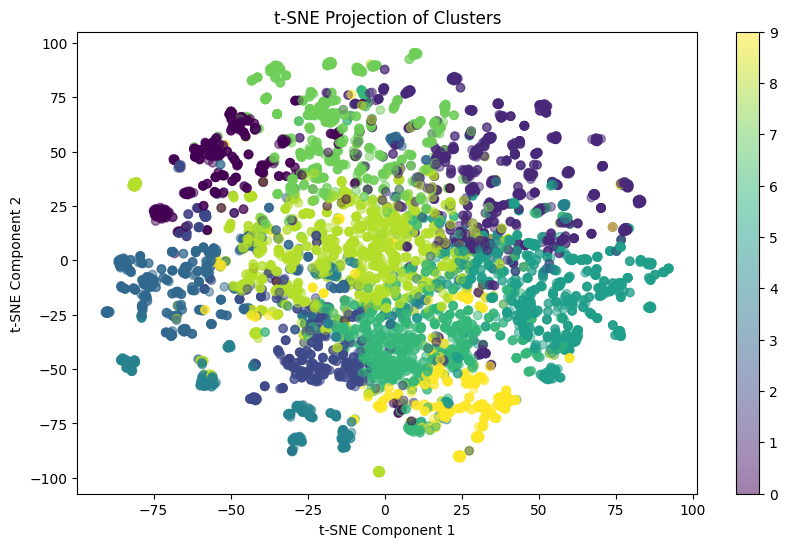

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.title("t-SNE Projection of Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar()
plt.show()

In [16]:
for i in range(10):
    print(f"Cluster {i}:")
    cluster_files = np.array(file_names)[kmeans_labels == i]
    print(cluster_files[:5])  # Print the first 5 files in this cluster
    print("\n")

Cluster 0:
['./sound_datasets/urbansound8k/audio/fold10/100648-1-0-0.wav'
 './sound_datasets/urbansound8k/audio/fold10/100648-1-1-0.wav'
 './sound_datasets/urbansound8k/audio/fold10/100648-1-2-0.wav'
 './sound_datasets/urbansound8k/audio/fold10/100648-1-3-0.wav'
 './sound_datasets/urbansound8k/audio/fold10/100648-1-4-0.wav']


Cluster 1:
['./sound_datasets/urbansound8k/audio/fold9/101729-0-0-1.wav'
 './sound_datasets/urbansound8k/audio/fold9/101729-0-0-11.wav'
 './sound_datasets/urbansound8k/audio/fold9/101729-0-0-12.wav'
 './sound_datasets/urbansound8k/audio/fold9/101729-0-0-13.wav'
 './sound_datasets/urbansound8k/audio/fold9/101729-0-0-14.wav']


Cluster 2:
['./sound_datasets/urbansound8k/audio/fold10/101382-2-0-10.wav'
 './sound_datasets/urbansound8k/audio/fold10/101382-2-0-12.wav'
 './sound_datasets/urbansound8k/audio/fold10/101382-2-0-20.wav'
 './sound_datasets/urbansound8k/audio/fold10/101382-2-0-21.wav'
 './sound_datasets/urbansound8k/audio/fold10/101382-2-0-29.wav']


Cluster 3